In [1]:
import uproot3
import numpy as np
import ROOT

Welcome to JupyROOT 6.24/04


In [2]:
file = uproot3.open("Sample/vertexperformance_AMVF.root")

In [3]:
file.keys()

[b'Truth_Vertex_PV_Selected;6',
 b'Truth_Vertex_PV_Selected;5',
 b'Reco_Vertex;4',
 b'Reco_Vertex;3',
 b'amvf;1']

In [4]:
truth_tree_arrays = file["Truth_Vertex_PV_Selected"].arrays(namedecode="utf-8")
reco_tree_arrays = file["Reco_Vertex"].arrays(namedecode="utf-8")

In [5]:
def Get_ind_best_reco_HS_sum_pt2(reco_tree_arrays, i_event):
    # Return the index of the best reconstructed HS via sum of pt^2 method 
    trk_pt_sq = ((1./reco_tree_arrays["reco_vtx_fitted_trk_qp"][i_event])*np.sin(reco_tree_arrays["reco_vtx_fitted_trk_theta"][i_event]) )**2
    n_vtx = len(reco_tree_arrays["reco_vtx_vz"][i_event])
    
    vtx_trk_pt_sq_sum = np.zeros(n_vtx)
    for i in range(n_vtx):
        vtx_trk_pt_sq_sum[i] = trk_pt_sq[reco_tree_arrays["reco_vtx_fitted_trk_vtxID"][i_event] == i].sum()
    
#     print(vtx_trk_pt_sqrt_sum)
    
    return vtx_trk_pt_sq_sum.argmax()

In [6]:
def Get_local_PU_density(truth_tree_arrays, i_event, xyz_dist_window = 2.0):
    # Calculate the PU density around the truth HS vertex 
    truth_vtx_vx = truth_tree_arrays["truth_vtx_vx"][i_event]
    truth_vtx_vy = truth_tree_arrays["truth_vtx_vy"][i_event]
    truth_vtx_vz = truth_tree_arrays["truth_vtx_vz"][i_event]
    
    dist_to_truth_HS = (truth_vtx_vx - truth_vtx_vx[0])**2 +(truth_vtx_vy - truth_vtx_vy[0])**2 + (truth_vtx_vz - truth_vtx_vz[0])**2 
    n_local_truth = len(np.where(dist_to_truth_HS< 2.0**2))
    return (n_local_truth - 1)/(2 * xyz_dist_window)
#     return local_PU_density 
    
    
    

In [7]:
%%time

canvas = ROOT.TCanvas()
hs_reco_eff = ROOT.TEfficiency("hs_reco_eff", "HS Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)
hs_sel_eff = ROOT.TEfficiency("hs_sel_eff", "HS selection and Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)


whole_match_matrix = []
# In the future, whole_match_matrix will be used to classify 

for i_event in range(len(reco_tree_arrays["event_id"])):
# for i_event in range(100):

    truth_vtx_vz = truth_tree_arrays["truth_vtx_vz"][i_event]
    reco_vtx_vz = reco_tree_arrays["reco_vtx_vz"][i_event]
    match_matrix = np.zeros((len(reco_vtx_vz),len(truth_vtx_vz)))
    # declare the truth-mathing matrix as a list, filled in the next 2 loops 
    # Can be normalized 

    for i in range(len(reco_vtx_vz)):
        for j in range(len(truth_vtx_vz)):
            test_truth = truth_tree_arrays["truth_vtx_fitted_trk_z0"][i_event][truth_tree_arrays["truth_vtx_fitted_trk_vtxID"][i_event] == j]
            test_reco = reco_tree_arrays["reco_vtx_fitted_trk_z0"][i_event][reco_tree_arrays["reco_vtx_fitted_trk_vtxID"][i_event] == i]
            match_matrix[i,j] = len(np.intersect1d(test_reco, test_truth))
            
    whole_match_matrix.append(match_matrix)
    
    
    # Find the index of best reco HS via 2 ways 
    ind_best_reco_HS_nTrk = match_matrix[:,0].argmax()
    ind_best_reco_HS_sumpt2 = Get_ind_best_reco_HS_sum_pt2(reco_tree_arrays, i_event)
    
    dist_best_reco_to_truth_HS_sq = (reco_tree_arrays["reco_vtx_vx"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vx"][i_event][0])**2 + (reco_tree_arrays["reco_vtx_vy"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vy"][i_event][0])**2 + (reco_tree_arrays["reco_vtx_vz"][i_event][ind_best_reco_HS_nTrk] - truth_tree_arrays["truth_vtx_vz"][i_event][0])**2 
    trhth_HS_vtx_recoed = False
    if dist_best_reco_to_truth_HS_sq < (0.1 ** 2):
        trhth_HS_vtx_recoed = True

    trhth_HS_vtx_seled = (bool)(ind_best_reco_HS_nTrk == ind_best_reco_HS_sumpt2)

    
    local_PU_density = Get_local_PU_density(truth_tree_arrays, i_event)
    hs_reco_eff.Fill(trhth_HS_vtx_recoed, local_PU_density)
    hs_sel_eff.Fill(trhth_HS_vtx_recoed and trhth_HS_vtx_seled, local_PU_density)
    

CPU times: user 23.2 s, sys: 411 ms, total: 23.6 s
Wall time: 23.4 s


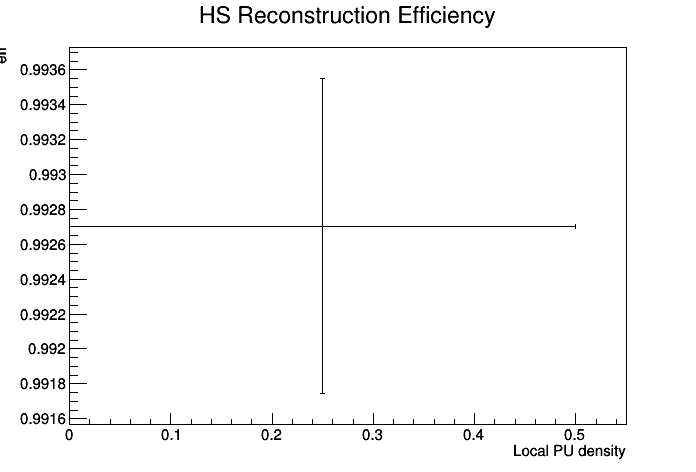

In [8]:
hs_reco_eff.Draw()
canvas.Draw()

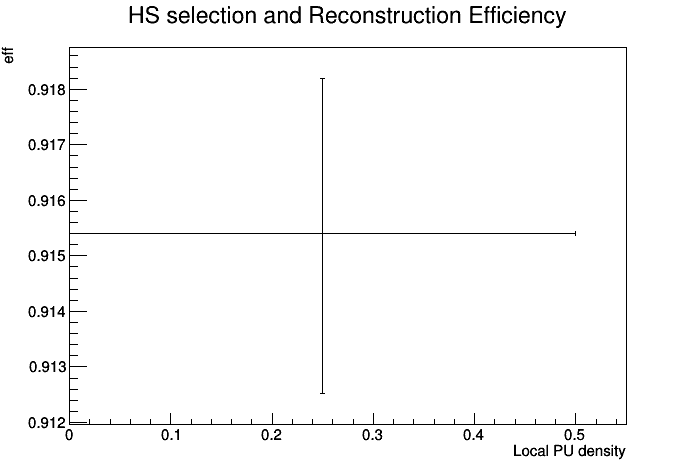

In [9]:
hs_sel_eff.Draw()
canvas.Draw()